In [3]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, f1_score  # Import f1_score
from sklearn.inspection import permutation_importance  # Import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
file_path = "../data/Lung_Cancer_Dataset_Corrupted.csv"
df = pd.read_csv(file_path)

In [5]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        imputer = SimpleImputer(strategy='median')
        df[col] = imputer.fit_transform(df[[col]]).flatten()

C:\Users\admin\AppData\Local\Temp\ipykernel_29748\1779797709.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [6]:
df['GENDER'] = df['GENDER'].round().astype(int)
df['AGE'] = df['AGE'].round().astype(int)
df['ENERGY_LEVEL'] = df['ENERGY_LEVEL'].round().astype(int)
df['OXYGEN_SATURATION'] = df['OXYGEN_SATURATION'].round().astype(int)

def winsorize(series, limits=(0.05, 0.05)):
    lower, upper = series.quantile(limits[0]), series.quantile(1 - limits[1])
    return series.clip(lower=lower, upper=upper)

df['ENERGY_LEVEL'] = winsorize(df['ENERGY_LEVEL'])
df['OXYGEN_SATURATION'] = winsorize(df['OXYGEN_SATURATION'])

df[df.columns[-1]] = df[df.columns[-1]].map({'YES': 1, 'NO': 0})

In [7]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
scaler = RobustScaler()  # Or StandardScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1', verbose=0)  # Use F1-score
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='f1')

In [10]:
best_svm = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [11]:
y_pred = best_svm.predict(X_test_scaled)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[553  82]
 [ 62 303]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       635
           1       0.79      0.83      0.81       365

    accuracy                           0.86      1000
   macro avg       0.84      0.85      0.85      1000
weighted avg       0.86      0.86      0.86      1000



In [12]:
result = permutation_importance(best_svm, X_test_scaled, y_test, n_repeats=30, random_state=42, scoring='f1') # Use f1 as scoring
importances = result.importances_mean

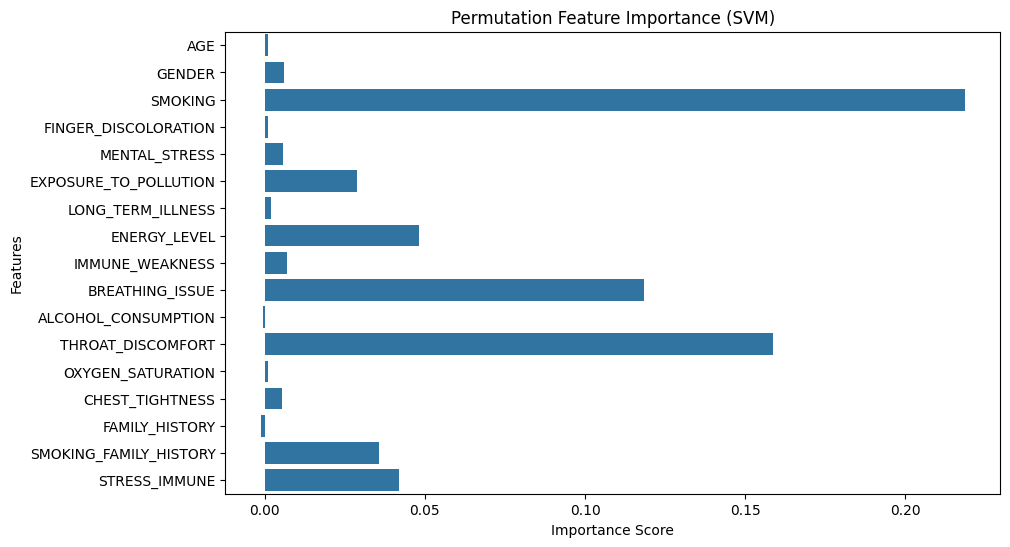

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=X.columns)
plt.title("Permutation Feature Importance (SVM)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [14]:
joblib.dump(best_svm, "svm_model.pkl")

['svm_model.pkl']